Aqui importamos os módulos os e shutil, que são utilizados para manipular ficheiros e caminhos/diretórios.

Defenimos tamabém os caminhos das pastas, onde estão contidos os conjuntos/set's de treino, validação e teste.

In [17]:
import os, shutil
train_dir = '../train'
validation_dir = '../validation'
test_dir = '../test'

Neste código seguinte, começamos por definir a variável IMG_SIZE. Tendo em conta que estamos a trabalhar com imagens de 32x32 pixeis, então, definimos essa mesma variável com o valor 150, porque, se usassem imagens de 32px, os feature maps acabariam por ficar com tamanhos inválidos devido ao tamanho da rede.

Criamos os conjuntos de dados de treino, validação e teste a partir dos respetivos diretórios. Assim, é especificado o caminho do diretório para cada um dos conjuntos anteriormente relatados.

O label_mode foi definido como categorical, tendo em conta que as etiquetas das imagens serão categóricas.

Posteriormente é definido o image_size, de forma a redimensionar todas as fotografias de input no respetivo conjunto, de forma a ter todas as fotografias do mesmo tamanho, sendo assim, se entrar na nossa rede uma fotografia 64x64, ela será redimensionada para o tamanho correto nesta fase.

In [18]:
from keras.utils import image_dataset_from_directory
IMG_SIZE = 150
train_dataset = image_dataset_from_directory(train_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE))
validation_dataset = image_dataset_from_directory(validation_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE))
test_dataset = image_dataset_from_directory(test_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE))

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


Devido ao grande fluxo de imagens que compõem este projeto, e devido ao treino desta rede ser significativamente mais demorado e lento, decidimos dividir todos os dataset's, nomeadamente, validation e train em 3 dataset's distintos para cada conjunto, de forma a otimizar o tempo de treino da nossa rede.

In [19]:
from tensorflow import keras
from keras import layers
import tensorflow as tf
# Função para calcular o tamanho do dataset
def calculate_dataset_size(dataset):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    return dataset_size

# Função para dividir o dataset em três subsets
def split_dataset(dataset, fractions):
    dataset_size = calculate_dataset_size(dataset)
    split_sizes = [int(fraction * dataset_size) for fraction in fractions]
    
    dataset_1 = dataset.take(split_sizes[0])
    dataset_2 = dataset.skip(split_sizes[0]).take(split_sizes[1])
    dataset_3 = dataset.skip(split_sizes[0] + split_sizes[1])
    
    return dataset_1, dataset_2, dataset_3

# Frações do dataset que você quer dividir (devem somar 1)
fractions = [0.4, 0.3, 0.3]

# Dividir o dataset de treino em três subsets
train_dataset_1, train_dataset_2, train_dataset_3 = split_dataset(train_dataset, fractions)
validation_dataset_1, validation_dataset_2, validation_dataset_3 = split_dataset(validation_dataset, fractions)

# Calculando os tamanhos dos subsets de treino
split_train_size_1 = calculate_dataset_size(train_dataset_1)
split_train_size_2 = calculate_dataset_size(train_dataset_2)
split_train_size_3 = calculate_dataset_size(train_dataset_3)

# Calculando os tamanhos dos subsets de validação
split_validation_size_1 = calculate_dataset_size(validation_dataset_1)
split_validation_size_2 = calculate_dataset_size(validation_dataset_2)
split_validation_size_3 = calculate_dataset_size(validation_dataset_3)

# Mostrando os tamanhos dos subsets de treino
print(f"Tamanho do subset 1 do conjunto de treino: {split_train_size_1}")
print(f"Tamanho do subset 2 do conjunto de treino: {split_train_size_2}")
print(f"Tamanho do subset 3 do conjunto de treino: {split_train_size_3}")

# Mostrando os tamanhos dos subsets de validação
print(f"Tamanho do subset 1 do conjunto de validação: {split_validation_size_1}")
print(f"Tamanho do subset 2 do conjunto de validação: {split_validation_size_2}")
print(f"Tamanho do subset 3 do conjunto de validação: {split_validation_size_3}")

Tamanho do subset 1 do conjunto de treinamento: 500
Tamanho do subset 2 do conjunto de treinamento: 375
Tamanho do subset 3 do conjunto de treinamento: 375
Tamanho do subset 1 do conjunto de validação: 125
Tamanho do subset 2 do conjunto de validação: 93
Tamanho do subset 3 do conjunto de validação: 95


É nesta fase onde começamos a construir a nossa arquitetura da rede. Nomeadamente, começamos com a camada VGG19. A VGG19 é uma arquitetura de rede convolucional pré-treinada. Posteriormente, definidmos como trainable false para os pesos dessas camadas não serem alterados durante o processo de treino do modelo. 

Decidimos implementar este projeto recorrendo à VGG19 e não à VGG16 visto que, a VGG19 possui mais camadas convulucionais. Obviamente que, ao apostar nesta arquitetura, teremos treinos mais demorados, mas, muito provavelmente, resultados melhores também.

O facto da VGG19 ter mais camadas, implica que, eventualmente, capture mais caracteristicas (complexas e detalhadas). Porém, o modelo fica mais suscetivel a overfitting, caso o dataset de treino seja demasiado pequeno.

Neste código desativamentos os warning's de SSL, visto que, ao descarregar a VGG19 nos computadores MacBook eram apresentados erros. Assim, conseguimos esquivar-nos desses erros e utilizar a VGG19 tão bem quanto no Windows.

In [20]:
from keras.applications.vgg19 import VGG19


#código para ignorar o certificado digital do link seguinte
import ssl
import requests

# Disable SSL certificate verification
requests.packages.urllib3.disable_warnings()
ssl._create_default_https_context = ssl._create_unverified_context
#fim do erro do certificado-------------------

conv_base = VGG19(weights="imagenet", include_top=False) 
conv_base.trainable = False

Neste seguinte bloco de código, e tendo em conta o contexto desta rede especificamente, criámos um conjunto de características do nosso data augmentation. Assim, damos diferentes transformações às imagens de treino na nossa rede, tornando o treino melhor. Assim as transformações às imagens são as seguintes:

##### ->RandomFlip, realiza uma inversão horizontal da fotografia
##### ->RandomRotation, que roda aleatóriamente a fotografia
##### ->RandomZoom, que dá zoom à fotografia
##### ->RandomContrast, que dá contraste à fotografia
##### ->RandomBrightness, que dá mais brilho à fotografia
##### ->RandomTranslation, que realiza uma translação em altura e largua à fotografia

No que toca à data_augmentation, fomos para além dos tópicos abordados nas aulas, tornando assim a nossa rede mais vulnerável a variadas alterações nas fotografias, tornando-a mais ágil na deteção das nossas classes.

Este é, talvez, o ponto mais importante do nosso projeto. A arquitetura da nossa rede.

Começamos com a camada dos input's em que inicializamos a respetiva camada com a forma (IMG_SIZE, IMG_SIZE, 3), onde IMG_SIZE é a dimensão das imagens e 3 representa as três canais de cor (RGB).

Neste projeto, foi acrescentada uma camada de data augmentation em relação ao projeto sem data augmentation. Esta camada pode melhorar a robustez e o desempenho do modelo, ao criar modificações nas imagens de treino, ajudando a prevenir o overfitting ao expor o modelo a diferentes formas das mesmas imagens durante o processo de treino.

Depois,  pré-processamos os dados de entrada para serem compatíveis com a VGG19.

Posteriormente, passamos os dados pela base convolucional da VGG19 pré-treinada.

Utilizámos uma camada Flatten, para transformar o output da última camada convolucional num vetor.

Depois, utilizámos uma camada densa, com um dropout de 50%.

Depois, utilizámos outra camada densa, com um dropout de 50%.

Por fim, temos a camada de saída, que é, por sua vez, a camada classificadora, com 10 neurónios, um para cada classes existente no nosso projeto. Tendo em conta que não se trata de uma saída binária, utilizamos a função de ativação Sigmoid.

Procurámos também, o melhor valor para o learning-rate, procurando um valor que não fosse nem pequeno nem grande de mais.

In [21]:
from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential(
[
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg19.preprocess_input(x) 
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x) 
model = keras.Model(inputs, outputs)

Alterámos o Optimizer da rede utilizada nas aulas. Decidimos utilizar o optimizer Adam, que permite a adaptação da Taxa de aprendeizagem: O Optimizer Adam ajusta a taxa de aprendizagem (learning-rate) de cada parâmetro individualmente, tornando-o muito mais eficaz em situações onde a escala dos gradientes varia.

Aqui foi onde aplicámos alguns extras para além do que foi dado nas aulas. É neste o ponto onde é compilada a nossa rede. Porém, foram então utilizadas duas técnicas, nomeadamente:

##### EarlyStopping
O EarlyStopping interrompe o treino do nosso modelo quando a val_loss não apresenta melhora após um número especificado de épocas (10), prevenindo overfitting.

##### ReduceLROnPlateau
O ReduceLROnPlateau ajusta a taxa de aprendizagem quando a val_loss deixa de melhorar, ajudando o modelo a convergir de forma mais eficiente e dinâmica.

In [34]:
#A partir deste bloco iremos treinar o modelo para os sub datasets
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-2), metrics=['accuracy']) 

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

Aqui, neste código, fazemos o treino do nosso modelo, recorrendo a técnicas extra anteriormente relatadadas. Fizemos um treino para cada um dos dataset's anteriormente divididos, como foi relatado.

In [ ]:
history = model.fit(train_dataset_2, epochs=2, validation_data=validation_dataset_2, batch_size=64, callbacks=[early_stopping, reduce_lr])
model.save('models/ModelT_transferLearning_featureExtraction_WithDataAumentation.h5')

In [ ]:
history = model.fit(train_dataset_1, epochs=2, validation_data=validation_dataset_1, batch_size=64, callbacks=[early_stopping, reduce_lr]) 
model.save('models/ModelT_transferLearning_featureExtraction_WithDataAumentation.h5')

Epoch 1/2


500/500 [==============================] - 59s 118ms/step - loss: 19.9576 - accuracy: 0.3319 - val_loss: 7.3000 - val_accuracy: 0.5587 - lr: 1.0000e-04
Epoch 2/2
500/500 [==============================] - 61s 121ms/step - loss: 17.1834 - accuracy: 0.3387 - val_loss: 6.4238 - val_accuracy: 0.5655 - lr: 1.0000e-04


In [24]:
#Treinar o modelo por cima do modelo guardado anteriormente
load_model = keras.models.load_model('models/ModelT_transferLearning_featureExtraction_WithDataAumentation.h5')
history = load_model.fit(train_dataset_3, epochs=2, validation_data=validation_dataset_3, batch_size=64, callbacks=[early_stopping, reduce_lr]) 
model.save('models/ModelT_transferLearning_featureExtraction_WithDataAumentation.h5')

Epoch 1/2
375/375 [==============================] - 1050s 3s/step - loss: 8.2817 - accuracy: 0.7093 - val_loss: 3.3977 - val_accuracy: 0.8562 - lr: 1.0000e-04
Epoch 2/2
375/375 [==============================] - 1215s 3s/step - loss: 7.3208 - accuracy: 0.7153 - val_loss: 2.9042 - val_accuracy: 0.8647 - lr: 1.0000e-04


In [35]:
history = load_model.fit(train_dataset_1, epochs=5, validation_data=validation_dataset_1, batch_size=64, callbacks=[early_stopping, reduce_lr]) 

Epoch 1/5
500/500 [==============================] - 1636s 3s/step - loss: 4.1454 - accuracy: 0.7191 - val_loss: 1.4102 - val_accuracy: 0.8737 - lr: 1.0000e-04
Epoch 2/5
500/500 [==============================] - 2103s 4s/step - loss: 3.6705 - accuracy: 0.7219 - val_loss: 1.2792 - val_accuracy: 0.8760 - lr: 1.0000e-04
Epoch 3/5
500/500 [==============================] - 2000s 4s/step - loss: 3.2097 - accuracy: 0.7247 - val_loss: 1.2768 - val_accuracy: 0.8760 - lr: 1.0000e-04
Epoch 4/5
500/500 [==============================] - 2031s 4s/step - loss: 2.8453 - accuracy: 0.7309 - val_loss: 1.1277 - val_accuracy: 0.8733 - lr: 1.0000e-04
Epoch 5/5
500/500 [==============================] - 2134s 4s/step - loss: 2.6173 - accuracy: 0.7281 - val_loss: 1.0018 - val_accuracy: 0.8680 - lr: 1.0000e-04


Após ser realizado o treino do nosso modelo, procedemos, no seguinte bloco de código, à sua avaliação, tomando em conta o seu respetivo dataset (validation_dataset), anteriormente definido.

Mostramos também o valor da accuracy do modelo gerado pelo treino.

Por fim, guardamos o ficheiro do nosso modelo em formato h5. 

In [36]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)
model.save('models/ModelT_transferLearning_featureExtraction_WithDataAumentation.h5')

313/313 [==============================] - 1052s 3s/step - loss: 13.7692 - accuracy: 0.2775
val_acc: 0.2775000035762787


Com o seguinte exemplar de código, é pretendido realizar um gráfico época a época, onde são registados e visualizados os respetivos valores de accuracy e loss do nosso modelo. Este ponto é muito importante, para poder comparar a evolução entre as épocas de um treino, bem como, por exemplo, quando realizamos alterações à rede e queremos ver a evolução comparando com versões anteriores.

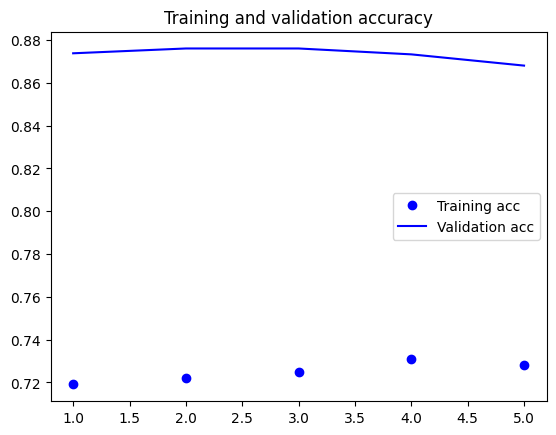

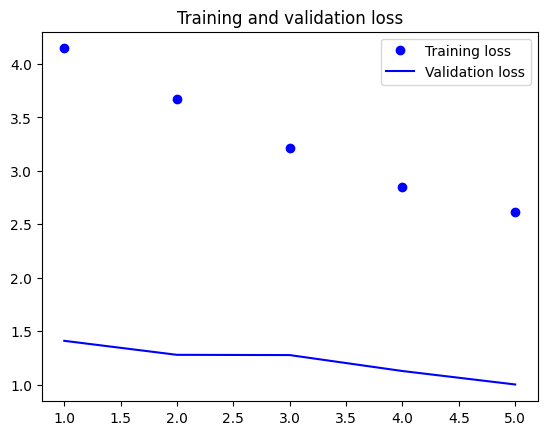

In [37]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

No seguinte bloco de código, é onde fazemos um predict depois do treino. Assim é feito o load do modelo em formato h5 após o respetivo treino. Após estar definido o caminho para as fotografias a serem utilizadas neste ponto, definimos também as label's das nossas classes e, por fim, apresentamos os resultados expectáveis do predicted vector e do probabilities vector. O vetor predicted mostra a classe a que corresponde a fotografia e o probabilities mostra as probabilidades da fotografia pertecer a uma dada classe. É de salientar que, neste ponto, utilizámos o seguinte ciclo for, de forma a fazer-mos um pequeno teste a cada classe do nosso projeto:
##### -> for label in labels:

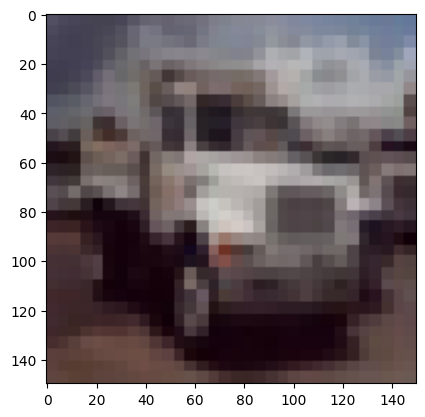

1/1 [==============================] - 0s 300ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Actual class: 009_truck ---- Predicted class: Truck
Predicted probabilities: [1.4804054e-09 5.1309871e-03 5.0518696e-19 7.7890318e-16 3.2405870e-11
 5.7954179e-13 5.4482313e-12 1.9411650e-18 2.3751088e-08 9.9486899e-01]


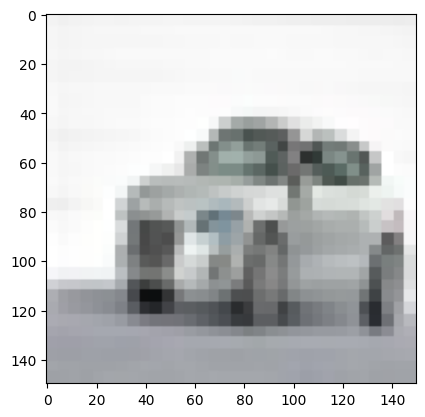

1/1 [==============================] - 0s 146ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Actual class: 001_automobile ---- Predicted class: Truck
Predicted probabilities: [2.32774109e-05 6.84458382e-06 1.26317195e-06 9.80801360e-08
 9.21568211e-10 1.14342695e-08 2.00661737e-03 3.81269729e-07
 6.20836345e-03 9.91753161e-01]


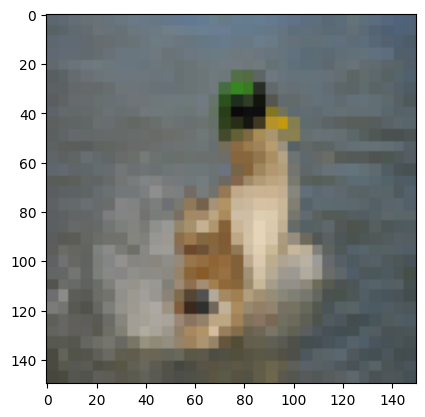

1/1 [==============================] - 0s 163ms/step
Predicted vector: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Actual class: 002_bird ---- Predicted class: Dog
Predicted probabilities: [6.4427371e-07 2.7241813e-05 1.8147103e-10 5.2574862e-05 2.5488905e-08
 4.4383150e-01 4.2324817e-01 3.7440206e-09 1.3272183e-01 1.1794716e-04]


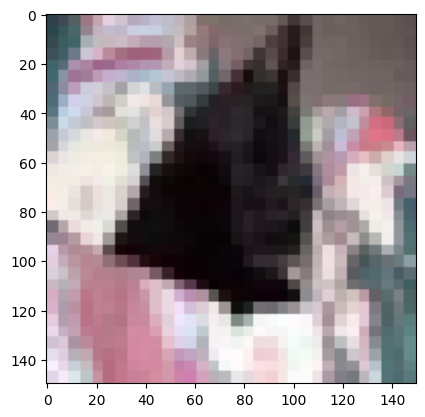

1/1 [==============================] - 0s 151ms/step
Predicted vector: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Actual class: 003_cat ---- Predicted class: Deer
Predicted probabilities: [1.6248480e-13 1.7163347e-10 9.0911612e-08 1.0724011e-06 9.9999881e-01
 2.4225044e-09 1.1377763e-17 1.4026117e-22 2.0156563e-09 2.3482791e-14]


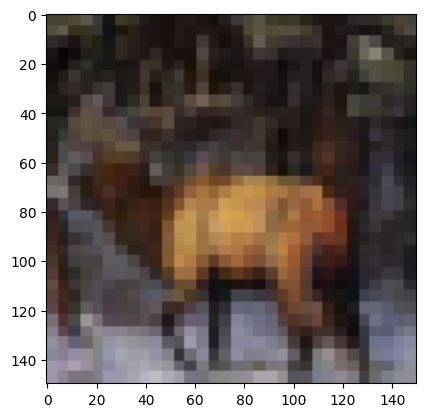

1/1 [==============================] - 0s 156ms/step
Predicted vector: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 004_deer ---- Predicted class: Automobile
Predicted probabilities: [1.8238081e-11 9.8658597e-01 3.0806845e-15 4.2704027e-13 5.0360374e-09
 1.3414010e-02 4.4805950e-21 2.3780500e-26 4.5762149e-17 1.5704482e-09]


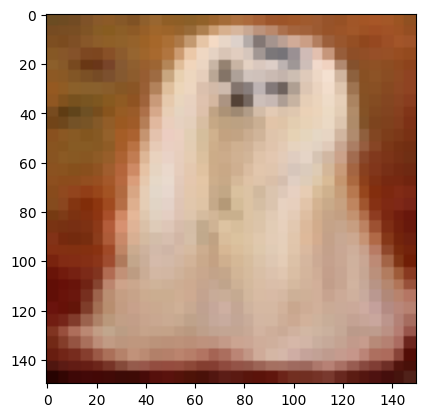

1/1 [==============================] - 0s 125ms/step
Predicted vector: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Actual class: 005_dog ---- Predicted class: Dog
Predicted probabilities: [5.5551954e-02 1.2868160e-02 8.1940452e-06 2.8541365e-07 1.3587093e-01
 7.9029071e-01 5.0824159e-03 1.7768538e-17 4.4286408e-05 2.8310303e-04]


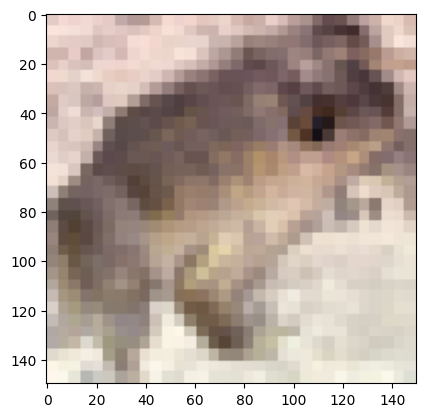

1/1 [==============================] - 0s 120ms/step
Predicted vector: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Actual class: 006_frog ---- Predicted class: Deer
Predicted probabilities: [8.7842316e-05 3.5819847e-02 2.1138295e-04 5.8211113e-04 6.2407982e-01
 3.4377539e-05 1.9946749e-05 1.3098652e-12 3.7838960e-05 3.3912677e-01]


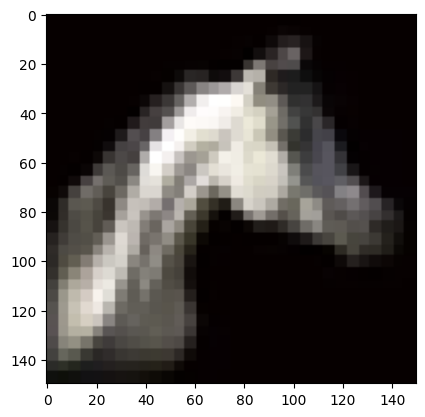

1/1 [==============================] - 0s 159ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Actual class: 007_horse ---- Predicted class: Truck
Predicted probabilities: [9.5871332e-11 3.8801276e-10 2.3312210e-14 1.3695455e-13 8.6228123e-15
 5.7723840e-13 1.0486570e-11 2.6109762e-23 1.3622697e-12 1.0000000e+00]


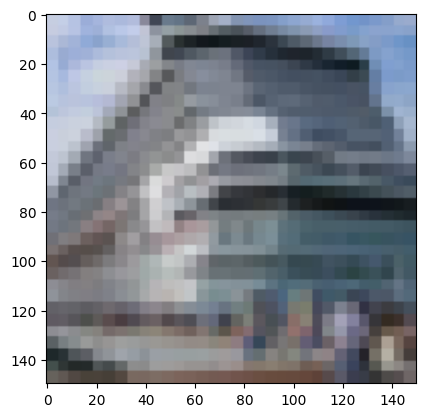

1/1 [==============================] - 0s 158ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Actual class: 008_ship ---- Predicted class: Truck
Predicted probabilities: [1.4176039e-01 8.5271853e-07 1.0225692e-07 1.3802651e-05 3.7543793e-07
 1.3734320e-01 8.8546728e-04 1.7347108e-07 5.6073277e-06 7.1999007e-01]


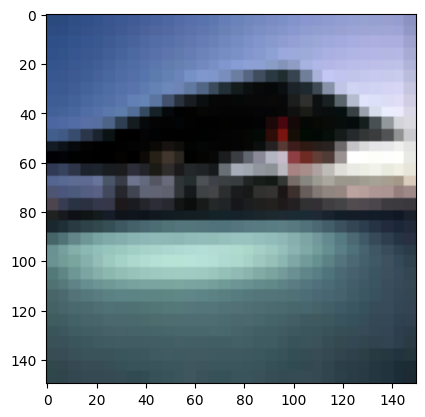

1/1 [==============================] - 0s 207ms/step
Predicted vector: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 000_airplane ---- Predicted class: Automobile
Predicted probabilities: [2.1468871e-03 7.6202226e-01 2.3556693e-16 1.3800454e-13 1.6236107e-14
 7.0963316e-02 5.0918412e-09 4.0080107e-07 2.9395038e-02 1.3547210e-01]


In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow import keras
import os

IMG_SIZE = 150

# Carrega o modelo gerado
model = keras.models.load_model('models/ModelT_transferLearning_featureExtraction_WithDataAumentation.h5')

# Função para prever a classe de uma imagem
def predict_image_class(label):
    # Diretório das imagens de treino
    img_dir = f'../train/{label}'
    
    # Lista de ficheiros de imagem no diretório
    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Seleciona uma imagem aleatória da lista
    random_image = random.choice(image_files)
    img_path = os.path.join(img_dir, random_image)
    
    # Carrega e exibe a imagem
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    plt.show()
    
    # Prepara a imagem para a Prediction
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Realiza a Prediction
    predictions = model.predict(img_array)

    # Vetor de probabilidades estatísticas
    predicted_probabilities = predictions[0]
    
    # Determina a classe prevista
    predicted_class_index = np.argmax(predictions)
    
    # Vetor de Precitions
    predicted_vector = np.zeros_like(predictions)
    predicted_vector[0, predicted_class_index] = 1
    
    # índices de classes para as labels
    class_labels = {
        0: "Airplane",
        1: "Automobile",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck"
    }
    
    # Obtém a label da classe prevista
    predicted_label = class_labels[predicted_class_index]
    
    # Exibe os resultados
    print(f"Predicted vector: {predicted_vector}")
    print(f"Actual class: {label} ---- Predicted class: {predicted_label}")
    print(f"Predicted probabilities: {predicted_probabilities}")


# Lista de labels para prever
labels = ['009_truck', '001_automobile', '002_bird', '003_cat', '004_deer', '005_dog', '006_frog', '007_horse', '008_ship', '000_airplane']

# Realiza predicitons para cada rótulo na lista (1 exemplo para cada classe)
for label in labels:
    predict_image_class(label)

Como principal extra do nosso projeto, para além do optimizer utilizado, tipos de data augmentation utilizados e outras funções que vão para além das utilizadas nas aulas, decidimos desenvolver um website que utiliza os modelos dos nossos notebook's. Assim, foi necessário utilizar o tensorflowjs_converter, que é uma biblioteca python, que permite converter o modelo de formato h5 para json, de forma a ser possível implementar a utilização do respetivo modelo no website. Posteriormente a este passo, e após termos o modelo em json, implementámos o código via JavaScript que faz a interligação entre o website e o modelo. O código JavaScript está disponível no ficheiro da diretoria ./web/main.js.

Para utilizar o nosso website, visto que não está publicado na web, é necessário instalar o VSCode e a respetiva externsão de live server, e correr o ficheiro index.html na diretoria ./web/index.html. A interação com a app web é simples, selecionar o tipo de modelo a ser utilizado, selecionar uma fotografia e realizar a operação de predict chamando o nosso modelo, por sua vez em json. Por fim, será apresentada uma label com a predicted class e também um gráfico de API Alphabet Google com as probabilidades para cada classe da nossa rede. O nosso website, permite também alternar entre tema claro e escuro, conforme a preferência do utilizador.

Assim, apresentamos um exemplo da interface web que podem esperar:

![GUI do website](../img/GUI.png "GUI do website")

Para gerir e trabalhar em grupo neste projeto, foi utilizado o software GitHub. O nosso repositório GitHub cumpre com toda a organização e logística que são essênciais para um projeto na nossa área. 

Explicação dos objetivos de cada pasta do nosso Repositório (Para respetiva consulta de informação):
##### Pasta DOC: Contém o enunciado do projeto
##### Pasta WEB: Contém o Website desenvolvido relatado anteriormente
##### Pastas TEST, VALIDATION e TRAIN: Contém os dataset's de teste, validação e treino, respetivamente, da nossa rede
##### Pasta NOTEBOOKS: Contém os nossos notebook's com output e comentários, bem como as suas versões clean e os modelos gerados pelo treino da rede bem como a conversão para JSON
##### Pasta RESULTS: Contém os resultados dos treinos das nossas redes (Importante a sua consulta)
##### Pasta IMG: Contém imagens auxiliáres
##### Ficheiro README: Contém a apresentação do projeto e a distinção das pastas de treino/validação (dataset's)
##### Ficheiro NOTAS: Contém notas que pretendemos guardas para consulta posterior (Apenas para partilhar informalção entre os membros do grupo)

Para consulta deixamos o seguinte link (carregar em cima da fotografia do ícone do GitHub):

[![GitHub](../img/github-logo.png)](https://github.com/goncaloferreira966/Projeto_IA)]

### Powered By:
##### Gonçalo Ferreira, nº 2222051
##### José Delgado, nº 2222049